In [1]:
from network import *
import numpy as np 
from scipy.sparse import csr_matrix
from scipy.stats import moment
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
#collecting data from csv file
data = np.genfromtxt("connections.csv", delimiter=",")
#matrix dimension
N = int(np.max(data)) + 1
#generating the sparse matrix from data
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
#making the network undirected
A = A + A.T
#removing multilinks
A = 1*(A > 0)

In [3]:
#getting the degrees of the matrix
kmin = 15
degrees = get_degrees(A)

#getting the pdf of the nodes degrees
uniques, pdf = get_neighbours_pdf(degrees)

#getting the cumulative distribution function
cumpdf = ccdf(pdf)

#estimating the parameters to be used in the power law
gamma, c = estimate_power_law(degrees, kmin)
C = c*cumpdf[np.where(uniques == kmin)]
print("gamma = ", gamma)
print("Average degree = ", np.mean(degrees))
print("Statistical power = ", moment(degrees, moment = 2))
print("Third moment = ", moment(degrees, moment = 3))
print(f"C = {c}")

gamma =  2.450748070781991
Average degree =  12.2991452991453
Statistical power =  [394.73957192]
Third moment =  [41757.00181942]
C = 73.75714995847152


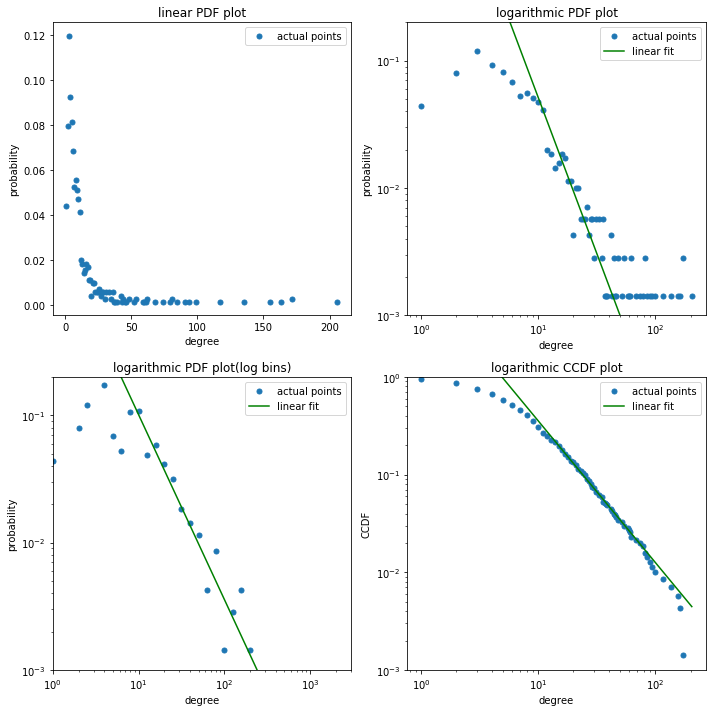

In [4]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

#plotting the pdf
axs[0, 0].set_title("linear PDF plot")
axs[0, 0].plot(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 0].set(xlabel='degree', ylabel='probability')
axs[0, 0].legend(["actual points"])

#plotting the pdf and the linear fit
axs[0, 1].set_title("logarithmic PDF plot")
axs[0, 1].set_ylim(1e-5, 1)
axs[0, 1].loglog(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 1].loglog(np.arange(1, np.max(uniques)), C * (np.arange(1, np.max(uniques)) ** -gamma), c="green")
axs[0, 1].set(xlabel='degree', ylabel='probability')
axs[0, 1].set_ylim(0.001, 0.2)
axs[0, 1].legend(["actual points", "linear fit"])

#plotting the linear binning pdf
axs[1, 0].set_title("logarithmic PDF plot(log bins)")
axs[1, 0].set_xlim(1, 3*10e2)
axs[1, 0].set_ylim(1e-4, 1)
x, y = log_binning_pdf(0.1, degrees)
axs[1, 0].loglog(x, y, marker='o', linestyle='None', ms = 5)
axs[1, 0].loglog(x, C / (gamma - 1) * x ** (1 - gamma) * (1 - (x[1] / x[0]) ** (1 - gamma)), c="green")
axs[1, 0].set(xlabel='degree', ylabel='probability')
axs[1, 0].set_ylim(0.001, 0.2)
axs[1, 0].legend(["actual points", "linear fit"])


#plotting the ccdf and the corresponding linear fit
axs[1, 1].set_title("logarithmic CCDF plot")
axs[1, 1].set_ylim((1e-5, 1))
axs[1, 1].loglog(uniques, ccdf(pdf), marker='o', linestyle='None', ms = 5)
axs[1, 1].loglog(np.arange(1, np.max(uniques)), C * np.arange(1, np.max(uniques))**(1-gamma)/(gamma-1), c="green")
axs[1, 1].set(xlabel='degree', ylabel='CCDF')
axs[1, 1].set_ylim(0.001, 1)
axs[1, 1].legend(["actual points", "linear fit"])

#used to prevent label overlapping
fig.tight_layout()

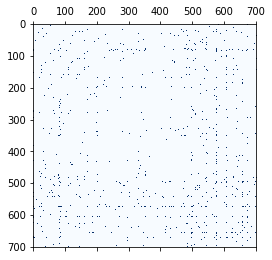

In [5]:
plt.matshow(A.toarray(), cmap="Blues")

In [6]:
#array that contains the name of each character so it's index is it's id
characters_id = []

#reading from file
with open("nodes.csv", "r") as fp:
    for line in fp:
        #for each line get name and id
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [7]:
#printing out the first three hubs in order from the biggest the the smallest
indexes = np.argsort(degrees, axis = 0)
for i in indexes[-1:-4:-1, 0]:
    print(characters_id[i])

Tyrion Lannister
Jaime Lannister
Arya Stark


In [8]:
A = clean_network(A)
print(f"Nodes removed beacuse not part of the GC : {N-A.shape[0]}")
N = A.shape[0]

Nodes removed beacuse not part of the GC : 0


max distance =  4.0
average distance =  2.693352191212391


Text(0.5, 1.0, 'Number of characters that need n hops to reach another character')

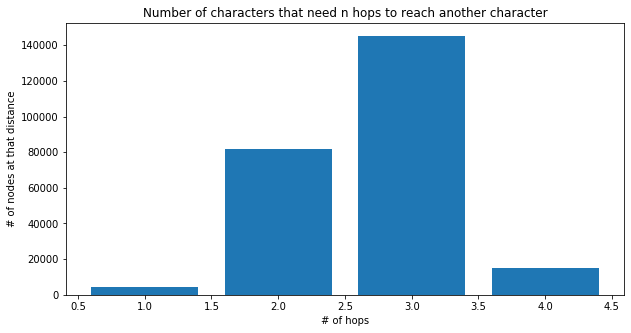

In [9]:
#getting unique distances and how many couple of nodes are at that distance
distances, counts = get_distance_distribution(A)

print("max distance = ", distances[-1])
print("average distance = ", np.sum(distances * counts)/np.sum(counts))

#plotting the distribution
plt.figure(figsize=(10, 5))
plt.bar(distances, counts)
plt.xlabel("# of hops")
plt.ylabel("# of nodes at that distance")
plt.title("Number of characters that need n hops to reach another character")

In [30]:
print(f"expected average distance {np.log(np.log(N))}")

expected average distance 1.8800653891059582


[Text(0, 0.5, 'Clustering Coefficients'), Text(0.5, 0, 'Degrees')]

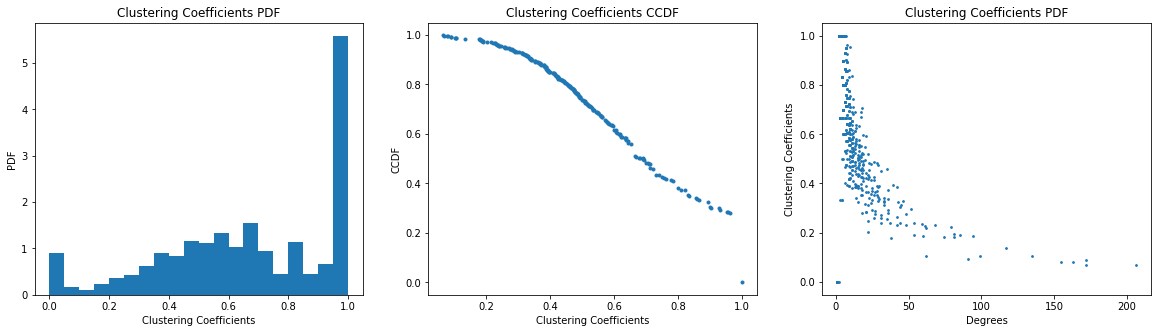

In [10]:
#getting the unique clustering values and their probability
x, y = get_clustering_distribution(A)

#getting the clustering coefficients
clustering = get_clustering_coefficients(A)

#plotting the distribution
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].hist(clustering, bins=20, density = True)
ax[0].set_title("Clustering Coefficients PDF")
ax[0].set(xlabel = "Clustering Coefficients", ylabel="PDF")
ax[1].plot(x, ccdf(y), marker=".", linestyle = "None")
ax[1].set_title("Clustering Coefficients CCDF")
ax[1].set(xlabel = "Clustering Coefficients", ylabel="CCDF")
ax[2].scatter(degrees, clustering, s = 3)
ax[2].set_title("Clustering Coefficients PDF")
ax[2].set(xlabel = "Degrees", ylabel="Clustering Coefficients")

In [11]:
print(f"mean clustering value : {np.mean(clustering)}, expected mean clustering value : {np.log(N)**2/N}")

mean clustering value : 0.6641911379562027, expected mean clustering value : 0.06118809553334096


mu = -0.22484447376121056
Natural cutoff = 1374.2639831073313
Structural cutoff = 92.91931984253867


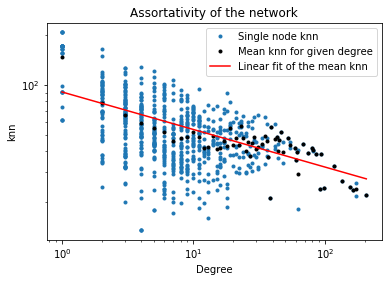

In [12]:
#getting values needed to compute assortativity of the network
p, unique, knn, temp_knn = get_assortativity_value(A)
degrees = remove_zeros(get_degrees(A))

#plotting knn distribution
plt.title("Assortativity of the network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'red')
plt.xlabel("Degree")
plt.ylabel("knn")
plt.legend(["Single node knn","Mean knn for given degree", "Linear fit of the mean knn"])
print(f"mu = {p[0]}")
print(f"Natural cutoff = {kmin * N ** (1 / (gamma - 1))}")
print(f"Structural cutoff = {np.sum(degrees)**0.5}")
plt.show()

mu : {p[0]}


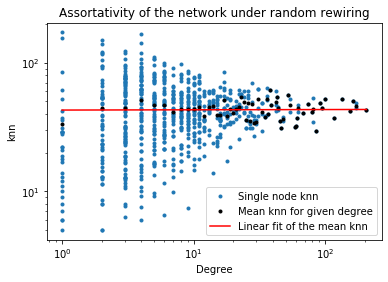

In [13]:
#getting a matrix built by rewiring A edges
B = random_rewiring(A)

#repeating what was previously done to find the assortatitvity value
p, unique, knn, temp_knn = get_assortativity_value(B)
degrees = remove_zeros(get_degrees(B))

plt.title("Assortativity of the network under random rewiring")
plt.xlabel("Degree")
plt.ylabel("knn")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
plt.legend(["Single node knn","Mean knn for given degree", "Linear fit of the mean knn"])
print("mu : {p[0]}")
plt.show()

In [14]:
#getting structural and natural cutoffs based on the relations in the barabasi book
natural_cutoff = kmin*N**(1/(gamma-1))
structural_cutoff = np.sum(degrees)**0.5

print(f"structural cutoff = {structural_cutoff}")
print(f"natural cutoff = {natural_cutoff}")

structural cutoff = 92.91931984253867
natural cutoff = 1374.2639831073313


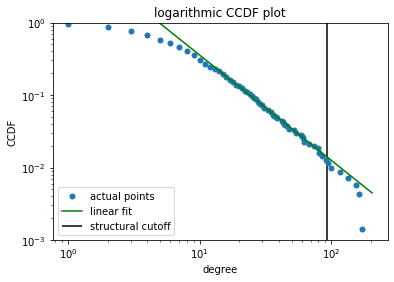

In [15]:
#showing where structural cutoff is

uniques, pdf = get_neighbours_pdf(degrees)

#getting the cumulative distribution function
cumpdf = ccdf(pdf)

#estimating the parameters to be used in the power law
gamma, c = estimate_power_law(degrees, kmin)
C = c*cumpdf[np.where(uniques == kmin)]
plt.title("logarithmic CCDF plot")
plt.ylim((1e-5, 1))
plt.loglog(uniques, ccdf(pdf), marker='o', linestyle='None', ms = 5)
plt.loglog(np.arange(1, np.max(uniques)), C * np.arange(1, np.max(uniques))**(1-gamma)/(gamma-1), c="green")
plt.xlabel('degree')
plt.ylabel('CCDF')
plt.ylim(0.001, 1)
plt.vlines(structural_cutoff, 1e-3, 1)
plt.legend(["actual points", "linear fit", "structural cutoff"], loc = "lower left")

In [16]:
#getting single chapters connections to build temporal evolution
nodes = [[]]
i = 0

with open("connections_for_temp.csv", "r") as fp:
    for line in fp:
        #chapters are separated by the word end so when it is found a new chapter begins
        if line == "end\n":
            i += 1
            nodes.append([])
        else:
            nodes[i].append([int(i) for i in line.replace("\n","").split(',')])            

In [17]:
#getting the temporal evloution of all character
temporal_distributions = get_temporal_distribution(N, nodes)

In [18]:
#function used to remove time steps where the degree doesn't improve
def parse_distribution(char_dist):
    
    #removing duplicates 
    char_dist_without_duplicates = set(char_dist)
    
    #since turning to a set might have unsorted the list it is sorted back 
    char_dist_sorted = list(char_dist_without_duplicates)
    char_dist_sorted.sort()

    return np.array(char_dist_sorted)

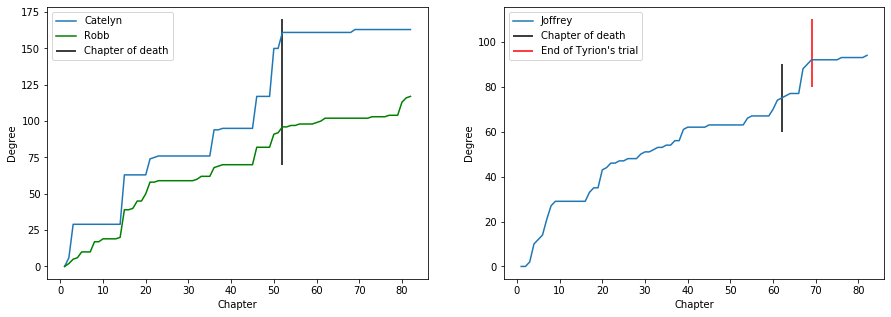

In [19]:
#getting temporal evolution for catelyn and robb
catelyn = temporal_distributions[:, characters_id.index("Catelyn Stark") ,0]
robb = temporal_distributions[:, characters_id.index("Robb Stark") ,0]

#plotting the evloution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(np.arange(1, 1 + len(catelyn)), catelyn)
ax[0].plot(np.arange(1, 1 + len(catelyn)), robb, c = "g")
ax[0].set(xlabel="Chapter", ylabel="Degree")
ax[0].vlines(52, 70, 170)
ax[0].legend(["Catelyn", "Robb", "Chapter of death"])

#getting the temporal evolution for geoffrey
joffrey = temporal_distributions[:, characters_id.index("Joffrey Baratheon") ,0]

#plotting the evolution
ax[1].plot(np.arange(1, 1 + len(joffrey)), joffrey)
ax[1].set(xlabel="Chapter", ylabel="Degree")
ax[1].vlines(62, 60, 90)
ax[1].vlines(69, 80, 110, color="red")
ax[1].legend(["Joffrey", "Chapter of death", "End of Tyrion's trial"], loc="upper left")

Text(0.5, 1.0, 'Degree Distribution over time in logarithmic scale')

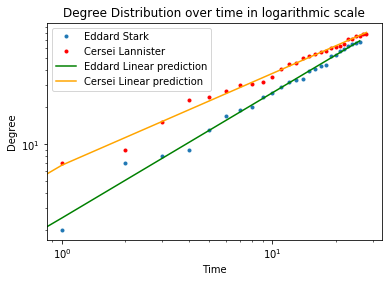

In [20]:
#getting the temporal evolution for eddard and cersei and removing non improvements
ned = temporal_distributions[:, characters_id.index("Eddard Stark") ,0]
cersei = temporal_distributions[:, characters_id.index("Cersei Lannister") ,0]
ned = parse_distribution(ned)
cersei = parse_distribution(cersei)

#fitting the logarithmic evolution in order to find the fitness
p_ned = sp.polyfit(np.log10(np.arange(1, len(ned))), np.log10(ned[1:]), 1)
p_cersei = sp.polyfit(np.log10(np.arange(1, len(cersei))), np.log10(cersei[1:]), 1)

plt.loglog(ned, linestyle = "None", marker=".")
plt.loglog(cersei, linestyle = "None", marker=".", c = "red")
plt.xlabel("Time")
plt.ylabel("Degree")
plt.loglog((10 ** p_ned[1]) * np.arange(len(ned)) ** p_ned[0], c = "green")
plt.loglog((10 ** p_cersei[1]) * np.arange(len(cersei)) ** p_cersei[0], c = "orange")
plt.legend(["Eddard Stark", "Cersei Lannister", "Eddard Linear prediction", "Cersei Linear prediction"])
plt.title("Degree Distribution over time in logarithmic scale")

In [22]:
coeffs = []
m = A.shape[0]

#evaluating all preferential attachment exponents
for i in range(m):

    #getting the temporal evolution of the ith character
    character = parse_distribution(temporal_distributions[:, i, 0])
    x = np.arange(1, len(character) + 1)
    
    #removing the 0 degrees because they cause preblems with the log
    if character[0] == 0:
        character = character[1:]
        x = x[1:]

    #finding the preferential attachment exponent only for characters with at least two points in the degree over time signal 
    if len(x) > 1:
        p = sp.polyfit(np.log(x), np.log(character), 1)
        coeffs.append(p[0])
    #otherwise just set the fitness to -1
    else: coeffs.append(-1)

coeffs = np.array(coeffs)
#selecting only positive exponents
useful_degrees = degrees[coeffs != -1]

#finding out the fitness
coeffs = coeffs[coeffs != -1] * c

In [21]:
#functions used in order to fit a gamma distribution
def gamma_CDF(x, alpha, beta):
    return sp.special.gammainc(alpha, beta*x)
def gamma_PDF(x, alpha, beta):
    return beta**alpha/sp.special.gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)

The parameters found for the gamma function are:
alpha = 4.422235422188573 with standard deviation 0.043385441282200496
beta = 0.04353806976103228 with standard deviation 0.0004614303899350863


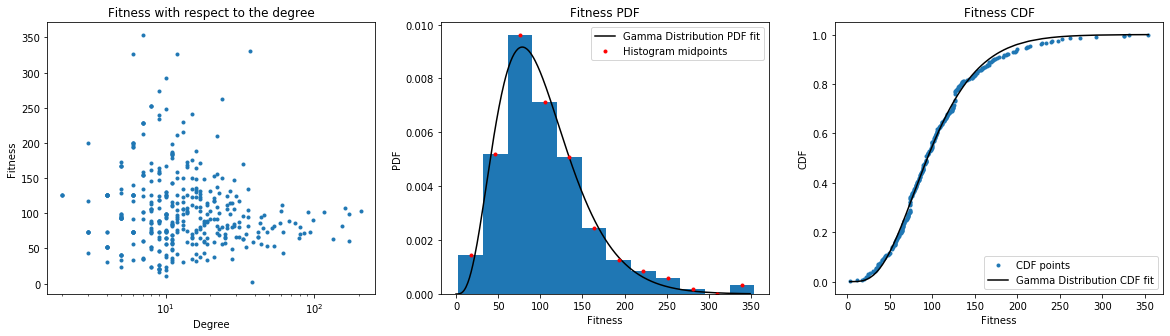

In [29]:
#plotting fitness distribution
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].plot(useful_degrees, coeffs, marker = '.', linestyle = "None")
ax[0].set(xscale = "log", xlabel="Degree", ylabel="Fitness")
ax[0].set_title("Fitness with respect to the degree")

#getting the parameters of the distribution
unique, pdf = get_neighbours_pdf(coeffs)
p, var = sp.optimize.curve_fit(gamma_CDF, unique, 1-ccdf(pdf))

counts, bins, _ = ax[1].hist(coeffs, density = True, bins = 12)
bin_cent = (bins[1:]+bins[:-1])/2

ax[1].plot(np.arange(0, 350, 1), gamma_PDF(np.arange(0, 350, 1), *p), c = "black")
ax[1].plot(bin_cent, counts, marker=".", linestyle="None", c = "red")
ax[1].set_title("Fitness PDF")
ax[1].set(xlabel = "Fitness", ylabel="PDF")
ax[1].legend(["Gamma Distribution PDF fit", "Histogram midpoints"])

ax[2].plot(unique, 1 - ccdf(pdf), marker = '.', linestyle="None")
ax[2].plot(unique, gamma_CDF(unique, *p), c = "black")
ax[2].set_title("Fitness CDF")
ax[2].set(xlabel = "Fitness", ylabel="CDF")
ax[2].legend(["CDF points", "Gamma Distribution CDF fit"])



print("The parameters found for the gamma function are:")
print(f"alpha = {p[0]} with standard deviation {var[0,0]**0.5}")
print(f"beta = {p[1]} with standard deviation {var[1, 1]**0.5}")

In [24]:
ids = np.argsort(coeffs)[::-1]
#printing most fit characters
print("The most fit characters are:")
print(characters_id[ids[0]])
print(characters_id[ids[1]])
print(characters_id[ids[2]])
print(characters_id[ids[3]])
print(characters_id[ids[4]])
print(characters_id[ids[5]])


The most fit characters are:
Garlan Tyrell
Grey-bearded Hamish
Joth Quick-bow
Gregor Clegane
Falyse
Helman Tallhart


In [31]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

#ignoring sparse efficiency warning because in this case it is not more efficient to use a lil_matrix
warnings.simplefilter('ignore',SparseEfficiencyWarning)

#getting parameters from random and hubs removal
random_removal, attack_removal = check_robustness(A)

For random removal inhomogeneity ratio goes below 2 when f = 0.9245014245014245
For attack removal inhomogeneity ratio goes below 2 when f = 0.23076923076923078


Text(0, 0.5, '$P_\\infty(f)/P_\\infty(0)$')

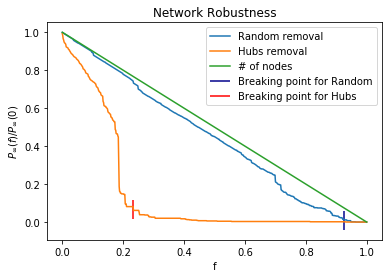

In [27]:
#getting the breaking points
inh_random = random_removal[1]
inh_attack = attack_removal[1]

#getting the GC dimensions
random = random_removal[0]
attack = attack_removal[0]

print(f"For random removal inhomogeneity ratio goes below 2 when f = {inh_random/N}")
print(f"For attack removal inhomogeneity ratio goes below 2 when f = {inh_attack/N}")

plt.plot(np.linspace(0, 1, N), np.array(random)/N)
plt.plot(np.linspace(0, 1, N), np.array(attack)/N)
plt.plot(np.linspace(0, 1, N),np.arange(N, 0, -1)/N)
plt.vlines(inh_random/N, -0.04, 0.06, colors = "darkblue")
plt.vlines(inh_attack/N, 0.02, 0.12, colors = "red")
plt.xlabel("f")
plt.title("Network Robustness")
plt.legend([
    "Random removal", 
    "Hubs removal", 
    "# of nodes", 
    "Breaking point for Random", 
    "Breaking point for Hubs"
])
plt.ylabel("$P_\infty(f)/P_\infty(0)$")